In [3]:
# Import relevant packages from jpype
from jpype import *

# Also import python packages for a demo
import numpy as np
import math
import pandas as pd
import matplotlib.pyplot as plt

1. JIDT information dynamics toolkit, see https://github.com/jlizier/jidt/

2. Estimation of mutual information for real-valued data with error bars and controlled bias. Caroline M. Holmes and Ilya Nemenman, Phys. Rev. E 100, 022404 – Published 6 August 2019 The last publication is useful to define the most optimal free parameter of the number of nearest neighbours in KNN statistics.


In [4]:
#start JVM by telling where the java path and the jar file you want to use are
# with java, it is useful to check whether JVM hasn't started yet
if isJVMStarted() == False:
    jarLocation = "/Users/vvasiliau/infodynamics.jar"  #where your jar file is
    startJVM(getDefaultJVMPath(),  "-ea", "-Djava.class.path=" + jarLocation)
    

# Trasfer entropy between financial time series



In [6]:
tsla = pd.read_csv("TSLA.csv")
tsla.index= pd.to_datetime(tsla.Date)
p_tsla= tsla["Close"]

spy = pd.read_csv("SPY.csv")
spy.index= pd.to_datetime(spy.Date)
p_spy= spy["Close"]

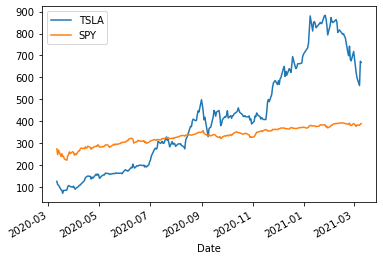

In [7]:
p_tsla.plot(label = "TSLA")
p_spy.plot(label = "SPY")
plt.legend()

<AxesSubplot:xlabel='Date'>

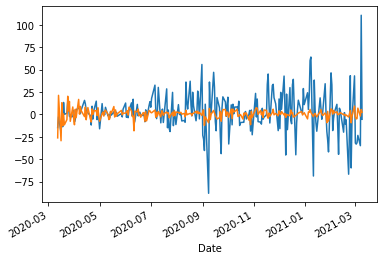

In [8]:
p_tsla.diff().plot()
p_spy.diff().plot()

In [9]:

# Using a KSG estimator for TE is the least biased way to run this:
teCalcClass = JPackage("infodynamics.measures.continuous.kraskov").TransferEntropyCalculatorKraskov
teCalc = teCalcClass();


teCalc.initialise(1,1,1,1,1);
teCalc.setProperty("k", str(4));
teCalc.setObservations(np.array(p_tsla.diff().dropna()),
            np.array(p_spy.diff().dropna()));


print("TESLA->SPY =  {}, p-value = {}".format(teCalc.computeAverageLocalOfObservations(),teCalc.computeSignificance(100).pValue ));

TESLA->SPY =  -0.03562265747783866, p-value = 0.9


In [10]:

# Using a KSG estimator for TE is the least biased way to run this:
teCalcClass = JPackage("infodynamics.measures.continuous.kraskov").TransferEntropyCalculatorKraskov
teCalc = teCalcClass();


teCalc.initialise(1,1,1,1,1);
teCalc.setProperty("k", str(4));
teCalc.setObservations( np.array(p_spy.diff().dropna()),np.array(p_tsla.diff().dropna()));


print("SPY->TESLA =  {}, p-value = {}".format(teCalc.computeAverageLocalOfObservations(),teCalc.computeSignificance(100).pValue ));

SPY->TESLA =  0.016121181917626792, p-value = 0.28


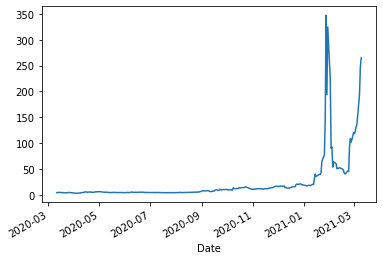

In [11]:


gme = pd.read_csv("GME.csv")
gme.index= pd.to_datetime(gme.Date)
p_gme= gme["Close"]

p_gme.plot()
p_gme = p_gme.diff()

In [25]:
D = pd.DataFrame([p_gme,p_tsla]).T.dropna()
D.columns = ["gme","tsla"]

# Using a KSG estimator for TE is the least biased way to run this:
teCalcClass = JPackage("infodynamics.measures.continuous.kraskov").TransferEntropyCalculatorKraskov
teCalc = teCalcClass();


teCalc.initialise(1,1,1,1,1);
teCalc.setProperty("k", str(4));
teCalc.setObservations( np.array(D["gme"]), np.array(D["tsla"]));


print("GME->TESLA =  {}, p-value = {}".format(teCalc.computeAverageLocalOfObservations(),teCalc.computeSignificance(100).pValue ));


# Using a KSG estimator for TE is the least biased way to run this:
teCalcClass = JPackage("infodynamics.measures.continuous.kraskov").TransferEntropyCalculatorKraskov
teCalc = teCalcClass();


teCalc.initialise(1,1,1,1,1);
teCalc.setProperty("k", str(4));
teCalc.setObservations( np.array(D["tsla"]), np.array(D["gme"]));

result = teCalc.computeAverageLocalOfObservations()
print("TESLA->GME =  {}, p-value = {}".format(result,teCalc.computeSignificance(1000).pValue ));

GME->TESLA =  0.013725378969767554, p-value = 0.14
TESLA->GME =  0.06551868001524519, p-value = 0.0


# Visualise statistical significance


In [13]:
teCalcNullDist = teCalc.computeSignificance(1000) #1000 surrogates

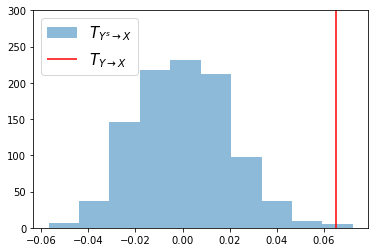

In [14]:
plt.hist(teCalcNullDist.distribution,10,alpha=0.5,label = "$T_{Y^s\\rightarrow X}$")
plt.vlines(result,0,300,color="red",label = "$T_{Y\\rightarrow X}$")
plt.ylim(0,300)
plt.legend(loc=2,fontsize =15)
plt.savefig("significance.pdf")

# Which knn parameter is optimal?

Simply, that for which we see the least bias. Subsample the dataset and compute the average TE as well as its variance. If TE is stable under subsampling, choice of nearest neighbours is OK.

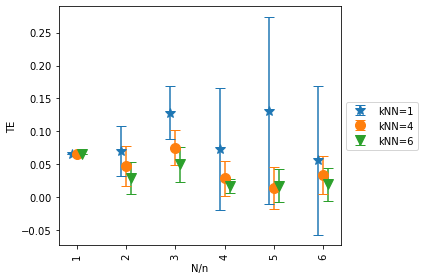

In [30]:

def calc_TE_subsampling(source,target,data,knn,kHistory,lHistory,freq= [2,3,4,5,6]):
    data = data[[source,target]].dropna()
    data = data.sort_index()
    N = len(data)
    result = [] 
    for f in freq:
        source_array,target_array= list(data[source]), list(data[target])
        while len(source_array) % f !=0:
            source_array.append(0)             
            target_array.append(0)
                
                
        target_array = np.array(target_array)
        source_array = np.array(source_array)
        source_array = source_array.reshape(-1,f)[:-1]
        target_array = target_array.reshape(-1,f)[:-1]
        for i in range(target_array.shape[1]):
            target_i,source_i = target_array[:,i],source_array[:,i]
            teCalc.initialise(kHistory,1,lHistory,1,1);
            teCalc.setProperty("k", str(knn));
            teCalc.setObservations(source_i,target_i)
            te= teCalc.computeAverageLocalOfObservations() 
            res = [f,target_array.shape[0],N,knn,source,target, te]
            result.append(res)
    
    result_dict= pd.DataFrame(result)
    result_dict.columns = ["freq","len_at_n","len_at_N","knn", "source", "target","TE"]
   
    
    return result_dict
        


result_df = pd.DataFrame()
knns = ["1","4","6"]
freq= [2,3,4,5,6]
for knnIndex in range(len(knns)):
    knn = knns[knnIndex];
    # Compute a TE value for knn nearest neighbours
    result_df= result_df.append(calc_TE_subsampling("tsla","gme",D,knn,1,1,freq))

shapes= ["*","o","v","^",">","P","d","p","s","+"]
result_df= result_df.sort_values(["freq"])
res = {}
err_res = {}
plt.figure()
shift = -0.1
i =0
for key,val in result_df.groupby("knn"):
    res_at_f = []
    err_at_f = []
    true_res =result
    res_at_f.append(true_res)
    err_at_f.append(0)


    for f,y_kf in val.groupby("freq"):
        res_at_f.append(y_kf.TE.astype(float).mean())
        err_at_f.append(y_kf.TE.astype(float).std())


    plt.errorbar([i+shift for i in range(len(res_at_f))],res_at_f,yerr = err_at_f,capsize = 5,label = "kNN="+str(key),
                 fmt = shapes[i],markersize=10)
    shift +=0.1
    i+=1
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xticks([i for i in range(0,len(freq)+1)],[1]+freq,rotation= 90)
plt.ylabel("TE")
plt.xlabel("N/n")
plt.tight_layout()